# Antibody sequences prediction

This notebook presents a step-by-step solution to design and evaluate a classical Machine Learning model to predict the label of amino acid sequences. It comprises four main sections:


1.   Data preprocessing
2.   Model training
3.   Model evaluation
4.   Performance discussion


The last cell in section 3 contains a predict function that can be used to score any input sequence(s).



## Data preprocessing

We start by loading the data and analyse it in order to understand its characteristics, detect and handle anomalies if they exist, and perform any necessary preprocessing steps.

### Load the dataset using pandas

In [ ]:
import pandas as pd

data = pd.read_csv("dataset.csv")

print("Dataset shape:", data.shape)

Dataset shape: (2109, 2)


### Exploratory data analysis
Show the first 5 rows

In [ ]:
data.head()

,amino_acid_sequence,label
0,EVRLVESGGGLVQPGGSLRLSCAASGLTFTNYDMSWVRQAPGKGLE...,0
1,QIQLQESGPGLLKPSETLSLTCAVSGGSIRSSWGAWIRQPPGKGLE...,0
2,QLHLQESGPGLVRPSETLSVTCAVSGVSISSTFWGWIRQAPGKGLE...,0
3,QVQLQESGPGLVKPSETLSLTCAVSGGSISDDFYWNWIRQPPGKGL...,0
4,QVHLQESGPGLLKPSETLSLTCVVSGGSLRSDWWGWIRQPPGKGLE...,0


Get further information including the total number of sequences and the data types

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109 entries, 0 to 2108
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   amino_acid_sequence  2109 non-null   object
 1   label                2109 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.1+ KB


Next, count the total number of classes

In [ ]:
import numpy as np

unq_classes = np.unique(data['label'].values)

print('Number of classes: ', len(unq_classes))

Number of classes:  2


Count the length of sequences (i.e. number of amino acide per sequence) and plot them in a histogram

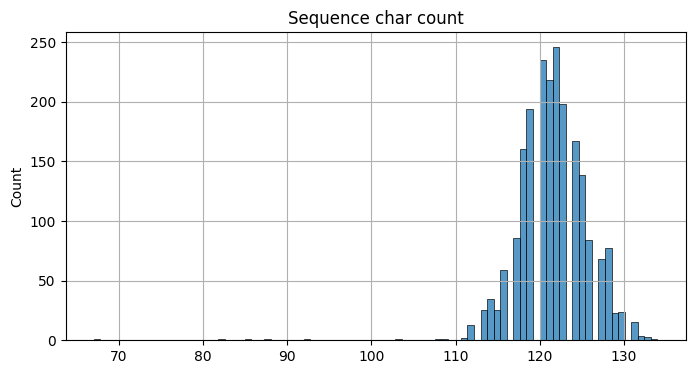

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

seq_length = data['amino_acid_sequence'].apply(lambda x: len(x))

plt.figure(figsize = (8,4))
plt.plot()
sns.histplot(seq_length.values)
plt.title(f'Sequence char count')
plt.grid(True)

plt.show()

**Observation**: most of the sequences have lengths between 110 and 135.

Next, count the total number of amino acid letter codes and their frequencies within the dataset. Then plot these frequencies in a histogram.

Total number of unique codes: 20


<Axes: title={'center': 'Code frequency'}, xlabel='Code', ylabel='Freq'>

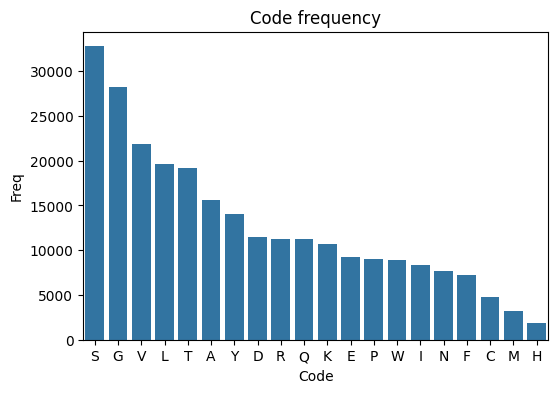

In [ ]:
from collections import Counter

seq = data["amino_acid_sequence"].apply(lambda x: " ".join(x))

codes = []
for i in seq: # concatination of all codes
  codes.extend(i)

codes_dict= Counter(codes)
codes_dict.pop(' ') # removing white space

print(f'Total number of unique codes: {len(codes_dict.keys())}')

code_freq = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
code_freq = code_freq.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

plt.figure(figsize = (6,4))
plt.title(f'Code frequency')
sns.barplot(x='Code', y='Freq', data=code_freq)

Count number of sequences per class

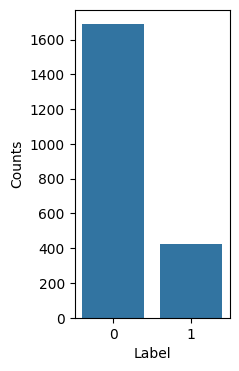

label
0    1687
1     422
dtype: int64

In [ ]:
label_counts = data["label"].value_counts()
temp_df = pd.DataFrame({
    "Label": label_counts.index,
    "Counts": label_counts.values
})

plt.figure(figsize = (2,4))
sns.barplot(x = "Label", y = "Counts", data = temp_df)
plt.show()

data.groupby('label').size().sort_values(ascending=False)

**Observation**: the dataset is clearly imbalanced since class "0" significantly outnumbers class "1" (1687 >> 422). This can lead to a biased model that performs poorly on the minority class. I will handle the class imbalance in the train set after splitting the dataset.

### Dataset splitting

I will split the dataset into 80:20 format, i.e. 80% will be used for training the model and the remaining 20% will be used to evaluate its performance. Note that in training, I will apply cross-validation on the train set to validate the model and tune the hyperparameters. More details on this will follow in the Model Training section.

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, train_size = 0.8, random_state=42, shuffle=True)
y_test = test['label']

print("Train set size", train.shape)
print("Test set size", test.shape)

Train set size (1687, 2)
Test set size (422, 2)


Check class imbalance in the train set

In [ ]:
train.groupby('label').size().sort_values(ascending=False)

label
0    1351
1     336
dtype: int64

### Handling class imbalance

As mentioned above, to obtain a more robust model, it is important to address the class imbalance. Below I apply Random Upsampling on the train set which is a simple and straightforward approach to augment the minority class. This is done by duplicating random instances from it until it is balanced with the majority class.

In [ ]:
from sklearn.utils import resample

minority_class = train[train['label'] == 1]
majority_class = train[train['label'] == 0]

# Upsample the minority class
minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

# Merge the upsampled minority class with the majority class
balanced_train = pd.concat([majority_class, minority_upsampled])

# Get the labels
y_train = balanced_train['label']

# Ensure that the train set is now balanced
balanced_train.groupby('label').size().sort_values(ascending=False)

label
0    1351
1    1351
dtype: int64

### Text preprocessing

Amino acid sequences are represented as strings of amino acids (letter codes) in a particular order. To build a machine learning model, this textual data needs to be transformed into a numerical format that can be processed by the machine. Further, these sequences have different lengths which is not suitable for a ML model. To address these two issues, I will apply an encoding which transforms each amino acid code into an integer. Then I will pad the sequences to the same length.

Below I create a dictionary of the 20 amino acids present in the dataset, each with its corresponding integer value. The dictionary will then be used for integer encoding.

In [ ]:
codes = ['S', 'G', 'V', 'L', 'T', 'A', 'Y', 'D', 'R', 'Q',
         'K', 'E', 'P', 'W', 'I', 'N', 'F', 'C', 'M', 'H']

def create_dict(codes):
  code_dict = {}
  for index, val in enumerate(codes):
    code_dict[val] = index+1

  return code_dict

code_dict = create_dict(codes)

print(code_dict)
print("Dictionary length:", len(code_dict))

{'S': 1, 'G': 2, 'V': 3, 'L': 4, 'T': 5, 'A': 6, 'Y': 7, 'D': 8, 'R': 9, 'Q': 10, 'K': 11, 'E': 12, 'P': 13, 'W': 14, 'I': 15, 'N': 16, 'F': 17, 'C': 18, 'M': 19, 'H': 20}
Dictionary length: 20


In [ ]:
def integer_encoding(data):
  """
    Encodes code sequence to integer values.
  """

  encode_list = []
  for row in data['amino_acid_sequence'].values:
    row_encode = []
    for code in row:
      row_encode.append(code_dict.get(code, 0))
    encode_list.append(np.array(row_encode))

  return encode_list

Encode the train and test sets

In [ ]:
train_encode = integer_encoding(balanced_train)
test_encode = integer_encoding(test)

### Sequence padding

As observed in the histogram of sequence lengths, the big majority of the sequences are of length between 110 and 135. I will pick a value from this interval (i.e. 130) and define it as the maximum length to pad the sequences.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

max_length = 130

train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')

train_pad.shape, test_pad.shape

((2702, 130), (422, 130))

## Model training

I will use two of the most widely used machine learning classifiers: **Random Forest** and **XGBoost**. They are both powerful tree-based ensemble-learning models which differ in their algorithmic techniques. Generally, their relative performance can vary depending on the task (dataset) at hand. Therefore I chose to train and evaluate both of them.

To validate the models and tune their hyperparameters, I will use K-Fold cross-validation where the train set is split into k subsets, then training of the model is performed on the k-1 subsets and the remaining one subset is used to evaluate its performance. For hyperparameters search, I will apply **Grid Search** which guarantees finding the optimal hyperparameters (among predefined candidates).

### Training a Random Forest classifier

The following cell performs hyperparameters tuning with Grid Search. Uncomment the last two lines if you would like to run it, but note that this step is too slow. Otherwise you can skip it and run the cell after which uses the parameters I tuned.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold


cv_split = KFold(n_splits=10, random_state=42, shuffle=True)

# Hyperparameters to be tuned
rf_hyperparam_grid={
    "n_estimators": [500, 1000, 1500],
    "min_samples_leaf": [1, 2, 5],
    "min_samples_split": [2, 3, 5],
    "criterion": ["gini"],
    "max_depth": [None]
}

grid_search_model = RandomForestClassifier(random_state=42)

rf_grid_search=GridSearchCV(
    estimator=grid_search_model,
    param_grid=rf_hyperparam_grid,
    scoring="accuracy",
    refit=True,
    return_train_score=True,
    cv=cv_split,
    verbose=10,
    n_jobs=-1,
)

#%time tuned_model = rf_grid_search.fit(train_pad, y_train)
#print("Optimal parameters: ", tuned_model.best_params_)
#print("Validation scores: ", tuned_model.cv_results_)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=1000,
                                  min_samples_leaf=1,
                                  min_samples_split=2,
                                  random_state=666)
rf_model.fit(train_pad, y_train)

rf_train_accuracy = rf_model.score(train_pad, y_train) * 100
print('Random Forest Train accuracy : {0:0.2f}'. format(rf_train_accuracy))

Random Forest Train accuracy : 100.00


### Training XGBoost classifier

Similarly to the previous model, uncomment the last two lines of the cell below to tune XGBoost's hyperparameters. Otherwise run the cell after to fit it with parameters I tuned.

In [ ]:
from xgboost import XGBClassifier

# Hyperparameters to be tuned
parameters = [{'n_estimators': [500, 1000, 1500],
               'reg_lambda': [0.15, 0.16, 0.17, 0.18],
               'max_depth':[None]}]

xgboost_model = XGBClassifier(random_state=42)

grid_search = GridSearchCV(estimator = xgboost_model,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = cv_split,
                           n_jobs = -1)

#grid_search = grid_search.fit(train_pad, y_train)
#print("best_parameters = {}".format(grid_search.best_params_))

In [ ]:
xgboost_model = XGBClassifier(n_estimators=500,
                              reg_lambda=0.16,
                              random_state=666)
xgboost_model.fit(train_pad, y_train)

xgboost_train_accuracy = xgboost_model.score(train_pad, y_train) * 100

print('XGBoost Train accuracy : {0:0.2f}'. format(xgboost_train_accuracy))

XGBoost Train accuracy : 100.00


## Model evaluation

After training the models, I will evaluate them using the unseen test data. In addition, to have further insights on the model performance, I will plot confusion matrices and calculate other classification metrics: precision, recall and F1-score. Finally, I will run a baseline experiment to evaluate the effect of the data augmentation step (i.e. dataset balancing). These results will be then discussed in the last section of this notebook.

In [ ]:
# Evaluate the random forest model using test data
rf_test_accuracy = rf_model.score(test_pad, y_test) * 100

# Evaluate the XGBoost model
xgboost_test_accuracy = xgboost_model.score(test_pad, y_test) * 100

Next, summarize results in a table (Table 1 for reference).

In [ ]:
from prettytable import PrettyTable

tab1 = PrettyTable()
tab1.field_names = ['Model', 'Train accuracy', 'Test accuracy']

tab1.add_row(['Random Forest', '{0:0.2f}'.format(rf_train_accuracy), '{0:0.2f}'.format(rf_test_accuracy)])
tab1.add_row(['XGBoost', '{0:0.2f}'.format(xgboost_train_accuracy), '{0:0.2f}'.format(xgboost_test_accuracy)])

print("Table 1:")
print(tab1)

Table 1:
+---------------+----------------+---------------+
|     Model     | Train accuracy | Test accuracy |
+---------------+----------------+---------------+
| Random Forest |     100.00     |     93.60     |
|    XGBoost    |     100.00     |     93.36     |
+---------------+----------------+---------------+


Next, plot confusion matrices as well as more evaluation metrics (precision, recall and F1-scores) for each of the models.

In [ ]:
def plot_cnf_matrix(cnf_matrix):

    #Plot the Confusion Matrix
    class_names=[0, 1]
    plt.figure(figsize = (4,4))
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.xlabel("Predicted Label")
    plt.ylabel('Actual label')

Random Forest evaluation

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       355
           1       0.73      0.94      0.82        67

    accuracy                           0.94       422
   macro avg       0.86      0.94      0.89       422
weighted avg       0.95      0.94      0.94       422



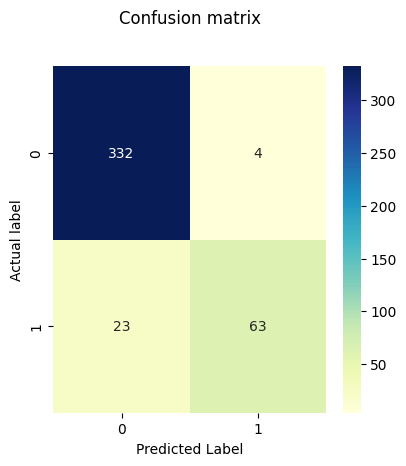

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

rf_predicted_test = rf_model.predict(test_pad)

cnf_matrix_rf = confusion_matrix(y_test, rf_predicted_test)

print(classification_report(rf_predicted_test, y_test))
plot_cnf_matrix(cnf_matrix_rf)

XGBoost evaluation

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       352
           1       0.74      0.91      0.82        70

    accuracy                           0.93       422
   macro avg       0.86      0.93      0.89       422
weighted avg       0.94      0.93      0.94       422



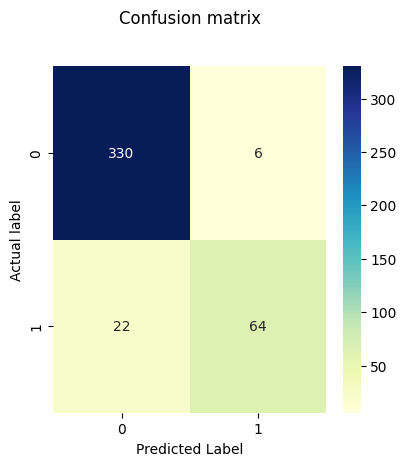

In [ ]:
xgboost_predicted_test = xgboost_model.predict(test_pad)

cnf_matrix_xgboost = confusion_matrix(y_test, xgboost_predicted_test)

print(classification_report(xgboost_predicted_test, y_test))
plot_cnf_matrix(cnf_matrix_xgboost)

**Baseline experiment:** here I will evaluate the effect of data augmentation on classification accuracy. I will pick the best performing model (i.e. Random Forest) and retrain it using the imbalanced train set. I will then evaluate it on the test set and compare the accuracies against the previously obtained result.  

In [ ]:
# Preprocess (encode) training data
imb_train_encode = integer_encoding(train)
imb_train_pad = pad_sequences(imb_train_encode, maxlen=max_length, padding='post', truncating='post')
y_train_imb = train['label']

# Fit a RF model using imbalanced data
rf_model_imb = RandomForestClassifier(n_estimators=1000, random_state=666)
rf_model_imb.fit(imb_train_pad, y_train_imb)

# Train accuracy
rf_imb_train_accuracy = rf_model_imb.score(imb_train_pad, y_train_imb) * 100

# Test accuracy
rf_imb_test_accuracy = rf_model_imb.score(test_pad, y_test) * 100


# Show a summary of results in a table (Table 2 for reference)
tab2 = PrettyTable()
tab2.field_names = ['Dataset type', 'RF Train accuracy', 'RF Test accuracy']

tab2.add_row(['Imbalanced', '{0:0.2f}'.format(rf_imb_train_accuracy), '{0:0.2f}'.format(rf_imb_test_accuracy)])
tab2.add_row(['Balanced', '{0:0.2f}'.format(rf_train_accuracy), '{0:0.2f}'.format(rf_test_accuracy)])

print("Table 2:")
print(tab2)

Table 2:
+--------------+-------------------+------------------+
| Dataset type | RF Train accuracy | RF Test accuracy |
+--------------+-------------------+------------------+
|  Imbalanced  |       100.00      |      92.42       |
|   Balanced   |       100.00      |      93.60       |
+--------------+-------------------+------------------+


### Prediction function

The following cell can be used to score any input sequence(s). The best performing model (Random Forest) will be used.

"input_seq" takes a list of amino acid sequences. You can update it with your input if you would like to make a prediction.

In [ ]:
input_seq = ["EVRLVESGGGLVQPGGSLRLSCAASGLTFTNYDMSWVRQAPGKGLEWVAHISFTGKTIYYADSVKGRFSISRDNANNSVSLQMNSLRAEDTAVYFCTRDLTMVATVYGLDSWGQGVVVIVSS"]

def predict_input(input, rf_model):

  test_encode = integer_encoding_2(input)
  test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')
  rf_pred = rf_model.predict(test_pad)

  return rf_pred

def integer_encoding_2(data):
  """
    Encodes code sequences to integer values.
  """

  encode_list = []
  for row in data:
    row_encode = []
    for code in row:
      row_encode.append(code_dict.get(code, 0))
    encode_list.append(np.array(row_encode))

  return encode_list

res = predict_input(input_seq, rf_model)
print("Output labels:", res)

Output labels: [0]


## Performance discussion

The training accuracy has reached 100% for both models and the mean cross- validation accuracy was around 99%. This tells us that the models fitted the training data very well and they were able to generalise to the validation subsets (i.e. no overfitting). Now from Table 1, we can observe that the performance on unseen (test) data has surpassed 93% for both models, which is quite promising. Also Random Forest has slightly outperformed XGBoost by 0.24%. For this reason, I will focus only on Random Forest results in the rest of the discussion.

The question to address now is why has the model failed to classify the remaining 6.4%? To answer it, we can firstly look at the confusion matrix where it is clearly seen that most of the misclassified samples (23 samples) belong to class "1", whereas only 4 samples from class "0" were misclassified. This observation can be confirmed by looking at the precision and F1-scores which are significantly lower for class "1" (precision is 0.74 for class "1" compared to 0.98 for class "0"). By these observations, we can conclude that the fitted model is slightly biased since it has learnt to classify class "0" better than the other class. This can be explained by the dataset imbalance that we have observed during the exploratory data analysis. In fact class "0" significantly outnumbers class "1" (1687 >> 422), and despite balancing the dataset by applying Random Upsampling, the bias still persists.

Finally, did this Random Upsampling improve the model performance? I have performed a baseline experiment to answer this question where I trained a Random Forest classifier using the initial imbalanced data, then I tested it on the same test set. Table 2 shows that indeed, there is an improvement of 1.18% thanks to this augmentation. However, it is still not enough to avoid the bias in the model. A better solution I would suggest here is to collect more data belonging to the minority class, or else apply more sophisticated data augmentation techniques which are based on deep learning generative models such as GANs or VAEs. Unlike Random Upsampling, these will not duplicate existing samples but they will generate new samples, hence increasing the variability within the dataset.  
